# Analysis for DFProfiler

This is a simple analysis notebook for dfprofiler.

## Imports

In [5]:
import logging
import json
import dask
import os
from pathlib import Path
from glob import glob
import zindex_py as zindex

In [6]:

import dask.dataframe as dd
from dask.distributed import Client, LocalCluster, progress, wait, get_client
from dask.distributed import Future, get_client

## Project Variables

In [7]:
app_root = str(Path(os.getcwd()).parent)

In [8]:
logging.basicConfig(
    level=logging.DEBUG,
    handlers=[
        logging.StreamHandler(),
    ],
    format="%(asctime)s [%(levelname)s]: %(message)s in %(pathname)s:%(lineno)d",
)

## Setup Dask Local Cluster

In [9]:
workers=4
cluster = LocalCluster(n_workers=workers)  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default
logging.info(f"Initialized Client with {workers} workers and link {client.dashboard_link}")

2024-08-02 06:42:21,456 [DEBUG]: Using selector: EpollSelector in /usr/lib/python3.10/asyncio/selector_events.py:54


2024-08-02 06:42:42,974 [INFO]: Initialized Client with 4 workers and link http://127.0.0.1:8787/status in /tmp/ipykernel_35983/1637310826.py:4


## Start Analysis

In [40]:

file=f"{app_root}/read_12_proc_unbuf.pfw.gz"
file_pattern = glob(file)
file_pattern

['/home/cc/datacrumbs/read_12_proc_unbuf.pfw.gz']

## Function to load trace data

In [41]:
def create_index(filename):
    index_file = f"{filename}.zindex"
    if not os.path.exists(index_file):
        status = zindex.create_index(filename, index_file=f"file:{index_file}",
                                     regex="id:\b([0-9]+)", numeric=True, unique=True, debug=False, verbose=False)
        logging.debug(f"Creating Index for {filename} returned {status}")
    return filename

def get_linenumber(filename):
    index_file = f"{filename}.zindex"
    line_number = zindex.get_max_line(filename, index_file=index_file, debug=False, verbose=False)
    logging.debug(f" The {filename} has {line_number} lines")
    return (filename, line_number)

def get_size(filename):
    conf = get_dft_configuration()
    if filename.endswith('.pfw'):
        size = os.stat(filename).st_size
    elif filename.endswith('.pfw.gz'):
        index_file = f"{filename}.zindex"
        line_number = zindex.get_max_line(filename, index_file=index_file,debug=False, verbose=False)
        size = line_number * 256
    logging.debug(f" The {filename} has {size/1024**3} GB size")
    return int(size)


def generate_line_batches(filename, max_line):
    batch_size = 16*1024
    for start in range(0, max_line, batch_size):
        end =  min((start + batch_size - 1) , (max_line - 1))
        logging.debug(f"Created a batch for {filename} from [{start}, {end}] lines")
        yield filename, start, end

def load_indexed_gzip_files(filename, start, end):
    index_file = f"{filename}.zindex"
    json_lines = zindex.zquery(filename, index_file=index_file,
                          raw=f"select a.line from LineOffsets a where a.line >= {start} AND a.line <= {end};", debug=False, verbose=False)
    logging.debug(f"Read {len(json_lines)} json lines for [{start}, {end}]")
    return json_lines

In [42]:
def load_profile(line):
    d = {}
    if line is not None and line !="" and len(line) > 0 and "[" != line[0] and line != "\n" :
        try:
            unicode_line = ''.join([i if ord(i) < 128 else '#' for i in line])
            val = json.loads(unicode_line)
            d["pid"] = val["pid"]
            d["tid"] = val["tid"]
            d["ts_us"] = int(val["ts"])
            if "args" in val:
                if "time" in val["args"]:
                    d["dur_sec"] = float(val["args"]["time"])
                if "freq" in val["args"]:
                    d["freq"] = val["args"]["freq"]
                if "size_sum" in val["args"]:
                    d["size_bytes"] = val["args"]["size_sum"]
                if "fname" in val["args"]:
                    d["filename"] = val["args"]["fname"]
            d["func_id"] = val["name"]
            d["cat"] = val["cat"]
        except Exception as error:
            logging.error(f"Processing {line} failed with {error}")
    return d

## Create Dask Dataframe

In [43]:
if len(file_pattern) > 0:
    dask.bag.from_sequence(file_pattern).map(create_index).compute()
    logging.info(f"Created index for {len(file_pattern)} files")
    total_size = dask.bag.from_sequence(file_pattern).map(get_size).sum()
    logging.info(f"Total size of all files are {total_size} bytes")
    max_line_numbers = dask.bag.from_sequence(file_pattern).map(get_linenumber).compute()
    logging.info(f"Max lines per file are {max_line_numbers}")
    json_line_delayed = []
    total_lines = 0
    for filename, max_line in max_line_numbers:
        total_lines += max_line
        for _, start, end in generate_line_batches(filename, max_line):
            json_line_delayed.append((filename, start, end))

    logging.info(f"Loading {len(json_line_delayed)} batches out of {len(file_pattern)} files and has {total_lines} lines overall")
    json_line_bags = []
    for filename, start, end in json_line_delayed:
        num_lines = end - start + 1
        json_line_bags.append(dask.delayed(load_indexed_gzip_files, nout=num_lines)(filename, start, end))
    json_lines = dask.bag.concat(json_line_bags)
    pfw_bag = json_lines.map(load_profile).filter(lambda x: "ts_us" in x)
    pfw_bag.take(1)

2024-08-02 06:48:30,509 [INFO]: Created index for 1 files in /tmp/ipykernel_35983/405840175.py:3
2024-08-02 06:48:30,518 [INFO]: Total size of all files are <dask.bag.core.Item object at 0x70785853f670> bytes in /tmp/ipykernel_35983/405840175.py:5
2024-08-02 06:48:30,581 [INFO]: Max lines per file are [('/home/cc/datacrumbs/read_12_proc_unbuf.pfw.gz', 142714)] in /tmp/ipykernel_35983/405840175.py:7
2024-08-02 06:48:30,585 [DEBUG]: Created a batch for /home/cc/datacrumbs/read_12_proc_unbuf.pfw.gz from [0, 16383] lines in /tmp/ipykernel_35983/2639451476.py:31
2024-08-02 06:48:30,587 [DEBUG]: Created a batch for /home/cc/datacrumbs/read_12_proc_unbuf.pfw.gz from [16384, 32767] lines in /tmp/ipykernel_35983/2639451476.py:31
2024-08-02 06:48:30,590 [DEBUG]: Created a batch for /home/cc/datacrumbs/read_12_proc_unbuf.pfw.gz from [32768, 49151] lines in /tmp/ipykernel_35983/2639451476.py:31
2024-08-02 06:48:30,592 [DEBUG]: Created a batch for /home/cc/datacrumbs/read_12_proc_unbuf.pfw.gz from 

In [44]:
columns = {'pid': "uint64[pyarrow]", 'tid': "uint64[pyarrow]",
           'ts_us': "uint64[pyarrow]", 'dur_sec': "float32[pyarrow]", 
           'freq': "uint64[pyarrow]", 'size_bytes': "uint64[pyarrow]", 'func_id': "string[pyarrow]", 
           'filename': "string[pyarrow]", 
           'cat': "string[pyarrow]"}

In [45]:
events = pfw_bag.to_dataframe(meta=columns)

In [46]:
events = events.repartition(npartitions=1).persist()
_ = wait(events)

In [47]:
events.head()

,pid,tid,ts_us,dur_sec,freq,size_bytes,func_id,filename,cat
0,0,0,0,<NA>,<NA>,<NA>,virtual_memory,<NA>,Memory
1,0,0,0,<NA>,<NA>,<NA>,io_stat,<NA>,Disk
2,0,0,0,<NA>,<NA>,<NA>,snetio,<NA>,Network
3,0,0,0,<NA>,<NA>,<NA>,io_stat,<NA>,Disk
4,0,0,0,<NA>,<NA>,<NA>,snetio,<NA>,Network


## Analysis

In [48]:
events["name"] = events["cat"] + " " + events["func_id"]

In [49]:
value = events.groupby("name")[["dur_sec"]].sum()
per = value / value.sum()
per.reset_index().query("dur_sec > 0.0").compute()

,name,dur_sec
4,app _Z10gen_randomB5cxx11i,0.0
5,app _fini,0.0
6,app _init,0.0
7,app main,0.0
8,block block_dirty_folio,0.0
...,...,...
302,vfs vfs_getattr_nosec,0.000002
303,vfs vfs_open,0.0
304,vfs vfs_statfs.part.0.isra.0,0.0
305,vfs vfs_statx,0.0


In [50]:
all_events = list(events["name"].unique().compute())
all_events

['Memory virtual_memory',
 'Disk io_stat',
 'Network snetio',
 'CPU utilization',
 'os_cache truncate_inode_pages_range',
 'sys openat',
 'map page_add_file_rmap',
 'map uprobe_munmap',
 'vfs ext4_getattr',
 'os_cache page_counter_cancel',
 'sys lseek',
 'sys close',
 'vfs vfs_getattr_nosec',
 'map __libc_realloc',
 'os_cache obj_cgroup_uncharge_pages',
 'map dma_direct_map_sg',
 'c malloc',
 'vfs ext4_inode_attach_jinode',
 'os_cache free_unref_page_prepare',
 'c shm_open',
 'sys read',
 'map fileno',
 'c fileno',
 'os_cache filemap_get_read_batch',
 'map ext4_sb_block_valid',
 'c close',
 'map vm_unmapped_area',
 'map llseek',
 'map next_uptodate_page',
 'map fcntl',
 'os_cache page_rmapping',
 'map tlb_batch_pages_flush',
 'ext4 ext4_sample_last_mounted',
 'map shm_open',
 'map htab_map_update_elem',
 'map page_rmapping',
 'map _start',
 'c mmap64',
 'os_cache free_unref_page_commit',
 'os_cache balance_dirty_pages_ratelimited_flags',
 'os_cache mark_page_accessed',
 'map cap_mmap_f

In [51]:
events["cat"].unique().compute()
ignore_category = ["Memory", "Network", "Disk", "CPU", "app"]

In [52]:
ext4_events = [s for s in all_events if "ext4" in s]
libc_events = [s for s in all_events if "c " in s]
vfs_events = [s for s in all_events if "vfs " in s]
sys_events = [s for s in all_events if "sys " in s]
block_events = [s for s in all_events if "block " in s]
os_cache_events = [s for s in all_events if "os_cache " in s]
final_events = []
final_events.extend(ext4_events)
final_events.extend(libc_events)
final_events.extend(vfs_events)
final_events.extend(sys_events)
final_events.extend(block_events)
final_events.extend(os_cache_events)
final_events

['vfs ext4_getattr',
 'vfs ext4_inode_attach_jinode',
 'map ext4_sb_block_valid',
 'ext4 ext4_sample_last_mounted',
 'map ext4_file_mmap',
 'ext4 ext4_dx_readdir',
 'ext4 filemap_get_entry',
 'ext4 ext4_get_group_desc',
 'ext4 ext4_release_file',
 'ext4 ext4_file_mmap',
 'ext4 free_unref_page_list',
 'ext4 ext4_sb_block_valid',
 'ext4 filemap_get_read_batch',
 'ext4 ext4_es_lookup_extent',
 'ext4 ext4_convert_inline_data',
 'ext4 ext4_getattr',
 'ext4 __mod_node_page_state',
 'ext4 ext4_htree_store_dirent',
 'ext4 ext4_inode_journal_mode',
 'ext4 ext4_release_dir',
 'ext4 ext4_inode_csum',
 'ext4 ext4_fc_track_inode',
 'vfs ext4_sample_last_mounted',
 'ext4 ext4_inode_attach_jinode',
 'ext4 filemap_read',
 'ext4 ext4_ioctl',
 'map ext4_inode_csum',
 'ext4 folio_mapping',
 'ext4 ext4_journal_check_start',
 'ext4 ext4_nonda_switch',
 'ext4 block_dirty_folio',
 'ext4 ext4_inode_table',
 'ext4 __bio_add_page',
 'ext4 ext4_initialize_dirent_tail',
 'ext4 ext4_has_free_clusters',
 'map ext4_

In [53]:
selected_events = events[~events["cat"].isin(ignore_category)].compute()
selected_events["ts"] = selected_events["ts_us"] / 1e6
selected_events

,pid,tid,ts_us,dur_sec,freq,size_bytes,func_id,filename,cat,name,ts
117,35715,35715,0,0.000026,4,<NA>,truncate_inode_pages_range,<NA>,os_cache,os_cache truncate_inode_pages_range,0.0
118,35721,35721,0,0.000023,1,<NA>,openat,/usr/lib/x86_64-linux-gnu/openmpi/lib/openmpi3...,sys,sys openat,0.0
119,35719,35719,0,0.000016,1,<NA>,openat,/lib/x86_64-linux-gnu/libnl-3.so.200,sys,sys openat,0.0
120,35709,35709,0,0.014519,1855,<NA>,page_add_file_rmap,<NA>,map,map page_add_file_rmap,0.0
121,35721,35721,0,0.002097,414,<NA>,uprobe_munmap,<NA>,map,map uprobe_munmap,0.0
...,...,...,...,...,...,...,...,...,...,...,...
10960,35709,35709,267000000,0.000662,71,<NA>,page_remove_rmap,<NA>,map,map page_remove_rmap,267.0
10961,35700,35700,267000000,0.001197,132,<NA>,userfaultfd_unmap_complete,<NA>,map,map userfaultfd_unmap_complete,267.0
10962,35699,35699,267000000,0.00685,407,<NA>,__tlb_remove_page_size,<NA>,map,map __tlb_remove_page_size,267.0
10963,35704,35704,267000000,0.000007,1,<NA>,rw_verify_area,<NA>,vfs,vfs rw_verify_area,267.0


In [55]:
value = selected_events.groupby(["name","pid"])[["dur_sec"]].sum().groupby("name").max()
per = value
print(per.dtypes)
per = per.query("dur_sec > 0.1")
per

dur_sec    float[pyarrow]
dtype: object


,dur_sec
name,
c free,0.34961
c malloc,0.234928
ext4 bvec_try_merge_page,1.305948
ext4 ext4_es_lookup_extent,0.147238
ext4 ext4_sb_block_valid,0.932424
map __blk_bios_map_sg,0.435246
map __htab_map_lookup_elem,1.062591
map __libc_malloc,0.106732
map __mod_node_page_state,59.376499


In [194]:
grouped_events = selected_events.groupby(["ts","name"])["dur_sec"].sum()
grouped_events = grouped_events.reset_index()

In [195]:
selected_functions = list(grouped_events["name"].unique())

In [196]:
for fn in selected_functions:
    grouped_events[fn] = 0
    grouped_events[fn] = grouped_events[fn].mask(fn == grouped_events["name"], grouped_events["dur_sec"])
grouped_events

,ts,name,dur_sec,block block_devnode,block block_dirty_folio,block block_uevent,block mark_buffer_dirty,c calloc,c close,c fcntl,...,vfs vfs_unlink,c posix_memalign,block block_invalidate_folio,ext4 ext4_da_release_space,ext4 ext4_discard_preallocations,ext4 ext4_free_blocks,ext4 ext4_remove_blocks,ext4 ext4_truncate,vfs ext4_da_release_space,vfs vfs_rmdir
0,0.0,block block_devnode,0.000004,0.000004,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,block block_dirty_folio,0.000041,0.0,0.000041,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,block block_uevent,0.000003,0.0,0.0,0.000003,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,block mark_buffer_dirty,0.000006,0.0,0.0,0.0,0.000006,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,c calloc,0.02909,0.0,0.0,0.0,0.0,0.02909,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,16.0,vfs vfs_getattr_nosec,0.000132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
152,16.0,vfs vfs_open,0.00002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153,16.0,vfs vfs_rmdir,0.00002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00002
154,16.0,vfs vfs_statx,0.00003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
final_df = grouped_events.groupby("ts")[selected_functions].sum()
value = final_df.sum()
per = value / value.sum()
per.T

block block_devnode               0.0
block block_dirty_folio      0.000001
block block_uevent                0.0
block mark_buffer_dirty           0.0
c calloc                     0.000783
                               ...   
ext4 ext4_free_blocks        0.000002
ext4 ext4_remove_blocks      0.000002
ext4 ext4_truncate           0.000003
vfs ext4_da_release_space         0.0
vfs vfs_rmdir                     0.0
Length: 62, dtype: double[pyarrow]

In [198]:

per.T.plot(kind='pie', figsize=(5, 5))

AttributeError: 'bool' object has no attribute 'any'

Text(0, 0.5, 'Time (sec)')

<Figure size 640x480 with 0 Axes>

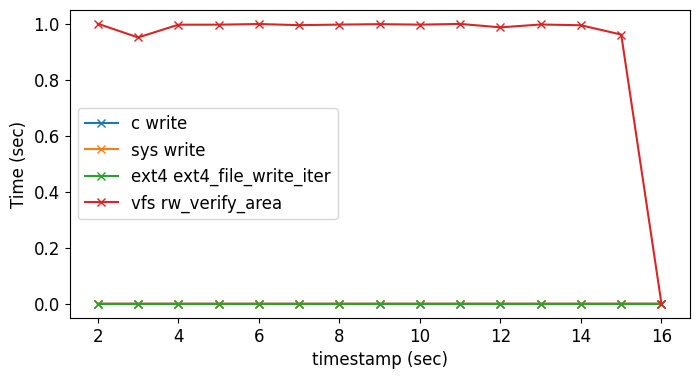

In [199]:
import matplotlib.pyplot as plt
plt.figure()
plt.rcParams.update({'font.size': 12})
ax = final_df.query("ts > 1")[["c write", "sys write", "ext4 ext4_file_write_iter","vfs rw_verify_area"]].plot(figsize=(8,4),marker='x');
ax.set_xlabel("timestamp (sec)")
ax.set_ylabel("Time (sec)")

Text(0, 0.5, 'Time (sec)')

<Figure size 640x480 with 0 Axes>

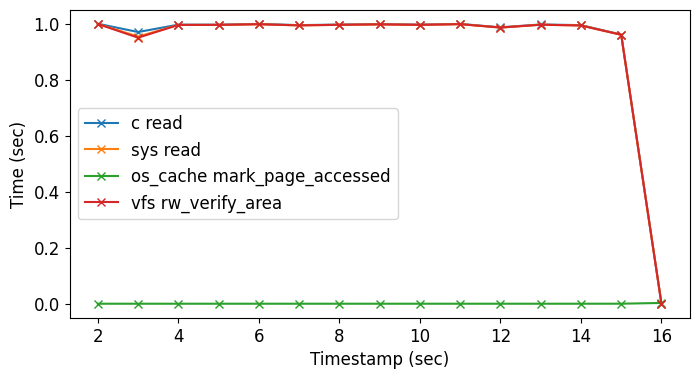

In [200]:
import matplotlib.pyplot as plt
plt.figure()
plt.rcParams.update({'font.size': 12})
ax = final_df.query("ts > 1")[["c read", "sys read", "os_cache mark_page_accessed", "vfs rw_verify_area"]].plot(figsize=(8,4),marker='x');
ax.set_xlabel("Timestamp (sec)")
ax.set_ylabel("Time (sec)")

In [63]:
final_df[["c read", "sys read", "os_cache mark_page_accessed","vfs rw_verify_area"]].sum()

c read                         14.954187
sys read                       14.917816
os_cache mark_page_accessed     0.003194
vfs rw_verify_area             14.911553
dtype: double[pyarrow]

In [15]:
events.query("func_id.str.contains('write')").compute()

,pid,tid,ts_us,dur_sec,freq,size_bytes,func_id,filename,cat
859,37818,37818,0,0.082555,112015,<NA>,ext4_da_write_begin,<NA>,ext4
936,37818,37818,0,0.000099,30,<NA>,write,<NA>,c
1425,37818,37818,0,0.000065,30,240,write,<NA>,sys
2491,37818,37818,0,0.002582,437,<NA>,write,<NA>,c
2607,37818,37818,0,0.001801,437,458227712,write,/home/cc/dfprofiler/build/data/file_0_0.dat,sys
...,...,...,...,...,...,...,...,...,...
5585,37818,37818,27000000,0.14544,80467,<NA>,ext4_da_write_end,<NA>,ext4
5588,37818,37818,27000000,0.000016,3,71,write,<NA>,sys
5590,37818,37818,27000000,0.00197,315,<NA>,write,<NA>,c
5602,37818,37818,27000000,0.06789,80467,<NA>,ext4_da_write_begin,<NA>,ext4


In [16]:
total_io = events["size_bytes"].sum().compute() / (1024**3)
total_io

np.float64(31.676917175762355)

In [17]:
filenames = events["filename"].unique().compute()
filenames

2024-07-22 01:24:23,458 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9400d42321dba2557730a45dee920254 initialized by task ('shuffle-transfer-9400d42321dba2557730a45dee920254', 0) executed on worker tcp://127.0.0.1:40747
2024-07-22 01:24:23,932 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9400d42321dba2557730a45dee920254 deactivated due to stimulus 'task-finished-1721611463.9289641'
2024-07-22 01:24:24,677 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a7bbad67b47d71bd4cb36976c19a97a4 initialized by task ('shuffle-transfer-a7bbad67b47d71bd4cb36976c19a97a4', 0) executed on worker tcp://127.0.0.1:40747
2024-07-22 01:24:25,071 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle a7bbad67b47d71bd4cb36976c19a97a4 deactivated due to stimulus 'task-finished-1721611465.0678325'
2024-07-22 01:24:25,193 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1a5a179e368417d8ea2ef928c4c79562 initialized by task ('shuffle-transfer-1a5a179e368417

0       /sys/devices/system/cpu/cpu15/cpufreq/cpuinfo_...
1                /sys/bus/pci/devices/0000:85:0f.7/config
2         /sys/devices/system/cpu/cpu12/cache/index0/size
3         /sys/devices/system/cpu/cpu17/topology/die_cpus
4                /sys/bus/pci/devices/0000:85:11.2/config
                              ...                        
1922    /sys/bus/pci/devices/0000:00:11.5/current_link...
1923    /sys/devices/system/cpu/cpu18/cache/index5/sha...
1924    /home/cc/spack/opt/spack/linux-ubuntu22.04-sky...
1925    /sys/devices/system/cpu/cpu32/cache/index4/sha...
1926                  /tmp/ompi.ebpf.1000/jf.0/2967207936
Name: filename, Length: 1927, dtype: string

In [18]:
read_write_time = events.query("size_bytes > 0").groupby(["pid","tid", "ts_us"])[["freq","dur_sec"]].sum().groupby(["ts_us"]).agg({"freq":sum,"dur_sec":max}).sum().compute()
read_write_time["dur_sec"], read_write_time["freq"]

(1.675211951136589, 35457.0)

In [19]:
print("Bandwidth is {} GB/s".format(total_io / read_write_time['dur_sec']))

Bandwidth is 18.909199611589667 GB/s


In [20]:
events.query("ts_us == 26000000").compute()

,pid,tid,ts_us,dur_sec,freq,size_bytes,func_id,filename,cat
5547,37818,37818,26000000,0.001643,379,397410304,write,/home/cc/dfprofiler/build/data/file_0_0.dat,sys
5548,37818,37818,26000000,0.000698,379,<NA>,lseek64,<NA>,c
5549,37818,37818,26000000,0.081353,96986,<NA>,ext4_da_write_begin,<NA>,ext4
5550,37818,37818,26000000,0.040467,97000,<NA>,ext4_da_reserve_space,<NA>,ext4
5551,37818,37818,26000000,0.037071,379,397410304,read,/home/cc/dfprofiler/build/data/file_0_0.dat,sys
5552,37818,37818,26000000,0.053109,97006,<NA>,mark_buffer_dirty,<NA>,os_cache
5553,37818,37818,26000000,0.07879,97014,<NA>,mark_buffer_dirty,<NA>,block
5554,37818,37818,26000000,0.000483,758,<NA>,rw_verify_area,<NA>,vfs
5555,37818,37818,26000000,0.173263,97020,<NA>,ext4_da_write_end,<NA>,ext4
5556,37818,37818,26000000,0.001427,379,<NA>,mark_buffer_dirty,<NA>,vfs


In [21]:
events.query("func_id.str.contains('read')").compute()

,pid,tid,ts_us,dur_sec,freq,size_bytes,func_id,filename,cat
1,37818,37818,0,0.000013,1,64,read,/sys/bus/pci/devices/0000:85:0f.7/config,sys
3,37818,37818,0,0.000002,1,8,read,/sys/devices/system/cpu/cpu15/cpufreq/cpuinfo_...,sys
5,37818,37818,0,0.000013,1,64,read,/sys/bus/pci/devices/0000:85:11.2/config,sys
13,37818,37818,0,0.000002,1,9,read,/sys/bus/pci/devices/0000:01:00.1/class,sys
16,37818,37818,0,0.000009,1,64,read,/sys/bus/pci/devices/0000:00:05.2/config,sys
...,...,...,...,...,...,...,...,...,...
5557,37818,37818,26000000,0.037668,379,<NA>,read,<NA>,c
5567,37818,37818,26000000,0.018482,188,197132288,read,/home/cc/dfprofiler/build/data/file_0_0.dat,sys
5573,37818,37818,26000000,0.018684,187,<NA>,read,<NA>,c
5579,37818,37818,27000000,0.031017,315,330301440,read,/home/cc/dfprofiler/build/data/file_0_0.dat,sys


In [22]:
events.query("ts_us == 24000000").compute()

,pid,tid,ts_us,dur_sec,freq,size_bytes,func_id,filename,cat
5515,37818,37818,24000000,0.081968,147784,<NA>,mark_buffer_dirty,<NA>,os_cache
5516,37818,37818,24000000,0.058051,577,<NA>,read,<NA>,c
5517,37818,37818,24000000,0.001194,577,<NA>,lseek,<NA>,c
5518,37818,37818,24000000,0.003649,578,<NA>,write,<NA>,c
5519,37818,37818,24000000,0.000367,577,<NA>,lseek,<NA>,sys
5520,37818,37818,24000000,0.001403,578,<NA>,ext4_file_write_iter,<NA>,ext4
5521,37818,37818,24000000,0.125021,147783,<NA>,ext4_da_write_begin,<NA>,ext4
5522,37818,37818,24000000,0.062439,147783,<NA>,ext4_da_reserve_space,<NA>,ext4
5523,37818,37818,24000000,0.001049,577,<NA>,lseek64,<NA>,c
5524,37818,37818,24000000,0.002207,578,<NA>,mark_buffer_dirty,<NA>,vfs


In [23]:
events["func_id"].unique().compute()

0                        close
1                         read
2                       openat
3                     vfs_open
4     vfs_statfs.part.0.isra.0
5                       open64
6                       statfs
7            mark_buffer_dirty
8               ext4_file_open
9                         open
10                  vfs_unlink
11         ext4_da_write_begin
12                       write
13                      malloc
14       ext4_da_reserve_space
15                    shm_open
16                       fcntl
17                     realloc
18                   vfs_statx
19                      fileno
20                      mmap64
21           vfs_getattr_nosec
22                       lseek
23                      calloc
24              PMPI_Comm_size
25              rw_verify_area
26                   PMPI_Init
27      _Z10gen_randomB5cxx11i
28                      fdopen
29              posix_memalign
30                vfs_readlink
31        ext4_file_write_iter
32      

In [24]:
events.query("cat == 'app'")["func_id"].unique().compute()

0    _Z10gen_randomB5cxx11i
1                     _init
2                      main
3                     _fini
Name: func_id, dtype: string

In [25]:
events.query("cat == 'mpi'")["func_id"].unique().compute()

0    PMPI_Comm_size
1         PMPI_Init
2    PMPI_Comm_rank
3     PMPI_Finalize
4       PMPI_Reduce
Name: func_id, dtype: string

In [26]:
functions = events.groupby(["func_id", "cat", "pid","tid", "ts_us"])[["freq","dur_sec"]].sum().groupby(["func_id", "cat", "ts_us"]).agg({"freq":sum,"dur_sec":max}).groupby([ "cat","func_id"]).sum()
functions = functions.reset_index()
functions.compute()

,cat,func_id,freq,dur_sec
0,app,_Z10gen_randomB5cxx11i,1,0.018685
1,app,_fini,1,0.000003
2,app,_init,1,0.000006
3,app,main,1,0.000006
4,block,mark_buffer_dirty,4152677,3.251503
5,c,calloc,3448,0.009626
6,c,close,1541,0.004579
7,c,fcntl,4,0.000009
8,c,fdopen,2,0.000009
9,c,fileno,7,0.000028


In [27]:
num_writes = functions.query("func_id == 'write' and cat == 'c'")
num_writes.compute()

,cat,func_id,freq,dur_sec
25,c,write,16253,0.100557


In [28]:
num_writes_ext4 = functions.query("func_id.str.contains('ext4_file_write_iter') and cat == 'ext4'")
num_writes_ext4.compute()

,cat,func_id,freq,dur_sec
30,ext4,ext4_file_write_iter,16231,0.037478


In [29]:
num_writes_os_cache = functions.query("func_id.str.contains('mark_buffer_dirty') and cat == 'os_cache'")
num_writes_os_cache.compute()

,cat,func_id,freq,dur_sec
36,os_cache,mark_buffer_dirty,4154656,2.143389


In [30]:
num_reads = functions.query("func_id == 'read' and cat == 'c'")
num_reads.compute()

,cat,func_id,freq,dur_sec
21,c,read,19198,1.634286


In [31]:
num_reads_ext4 = functions.query("func_id.str.contains('read') and cat == 'ext4'")
num_reads_ext4.compute()

,cat,func_id,freq,dur_sec


In [32]:
num_writes_os_cache = functions.query("func_id.str.contains('mark_page_accessed') and cat == 'os_cache'")
num_writes_os_cache.compute()

,cat,func_id,freq,dur_sec
37,os_cache,mark_page_accessed,1,0.000001


In [33]:
min_ts, max_ts = dask.compute(events["ts_us"].min(), events["ts_us"].max())

In [34]:
print(f"Application Time {(max_ts - min_ts) / 1e6} seconds")

Application Time 27.0 seconds


In [35]:
total_calls = events.freq.sum().compute()
total_calls

np.int64(21039362)

In [36]:
system_calls = events.query("cat == 'sys'")["freq"].sum().compute()
system_calls

np.int64(55236)

In [37]:
print(f"Events captured per system call {total_calls/system_calls}")

Events captured per system call 380.89944963429645


: 